# Configuração Inicial

Vaos importar algumas bibliotecas básicas.

In [1]:
import numpy as np
import pandas as pd
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(fig_id, format='png', dpi=600)

# Obtendo os dados

Vamos imporatar o conjunto de dados MNIST que está na biblioteca sklearn.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)

Vamos separar as imagens dos rótulos.

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Vamos salvar o nome das colunas de nosso dataset, pois precisaremos disso futuramente.

In [4]:
col=list(mnist.data.columns)
type(col)

list

# Conhecendo os dados

Note que nosso conjunto de dados são 70000 imagens, cada uma com 784 pixels. Porém a imagem está toda em uma linha, devemos transforma-la em algo que possamos ver, assim, perceba que 784=28x28, então para cada uma das linhas do conjunto de dados, podemos "quebrar" a linha em 28 partes de 28pixels cada e colocar esses pedaços um embaixo do outro para formar uma imagem 28x28. Cada um dos pixels (entradas de cada linha) é um valor numérico, para interpreta-los visualmente, vamos utilizar escalas de cinza, em que preto é 1 e branco é 0. Por fim, vamos utilizar o método de interpolação "nearest".

Abaixo segue um exemplo:

pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Name: 36000, Length: 784, dtype: int64
Saving figure some_digit_plot


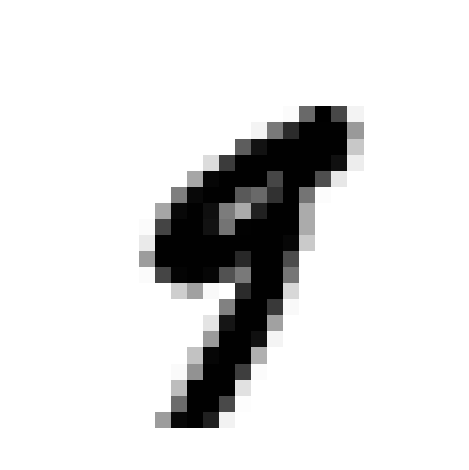

In [5]:
some_digit = X.iloc[36000]
print(some_digit)
some_digit_image = some_digit.to_numpy().reshape(28, 28)

plt.imshow(some_digit_image,
           cmap = mpl.cm.binary,
           interpolation= 'nearest')

plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [6]:
y.iloc[3600]

8

Aqui está uma função para facilitar futuros plots.

In [7]:
def plot_digit(data):
       image = data.to_numpy().reshape(28, 28)
       plt.imshow(image,
              cmap = mpl.cm.binary,
              interpolation= 'nearest')
       plt.axis("off")
       return plt.show()

# Separação de treino e teste

Vamos separar nossos dados da seguinte forma: as 60000 primeiras linhas serão para treino e as 10000 restantes para teste. Note que nossos dados já estão embaralhados, então não precisamos nos preocupar com isso agora.

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
type(y_train)

pandas.core.series.Series

# Data augmentation

Vamos agora aumentar nossa quantidade de dados em nosso conjunto de treino, a fim de melhorar a performance de nosso método. Cono estamos trabalhando com imagens, vamos fazer tranlações aleatórias das imagens e rotações de até 45°. Dessa forma, nosso método de machine leraning irá aprender a classificar imagens que não estão centralizadas e estão rotadas.

Antes de transladarmos, porém, precisamos saber em quanto podemos mover a imagem, pois não queremos que parte do número saia fora do escopo da imagem. Para isso vamos criar a função bounds, que encontra quanto podemos transladar uma imagem em cada direção (cima, baixo, esquerda e direita). Fazemos isso contando quantas linhas totalmente nulas (em branco) temos entes de linhas com valores não nulos (linhas que possuem parte de um número). Pensei em duas formas de encontrar os limites laterais, porém no final fiquei com minha primeira ideia (que segue abaixo), explicarei o motivo mais para frente.

In [10]:
def bounds(data):
    up_bound = 0
    dt = data.to_numpy().reshape(28, 28)
    for i in range(0,28):
        if any(dt[i,:]):
            break
        else:
            up_bound += 1
    lw_bound = 0
    for i in range(1,29):
        if any(dt[-i,:]):
            break
        else:
            lw_bound += 1
    lf_bound_list = []
    for i in range(up_bound,28-lw_bound):
        ds = dt[i,:]
        for j in ds:
            if j>0:
                lf_bound_list.append(list(ds).index(j))
    lf_bound = min(lf_bound_list)
    rt_bound_list = []
    for i in range(up_bound,28-lw_bound):
        nds = dt[i,:]
        for s in reversed(nds):
            if s>0:
                rt_bound_list.append(list(reversed(nds)).index(s))
    rt_bound = min(rt_bound_list)
    return up_bound,lw_bound,lf_bound,rt_bound

Agora, podemos transladar com segurança! Vamos sortear uma combiação entre [transladar para cima, transladar para baixo] e [transladar para esquerda, transladar para direita]. E depois vamos sortear em quantos pixels vamos transladar a imagem (dentro de um range determinado pelos limites calculados pela função bounds).

In [11]:
from random import randint

def translate(data):
    a = randint(0,1)
    b = randint(2,3)
    bnd = bounds(data)
    dt = data.to_numpy().reshape(28, 28)
    T=dt
    if bnd[a] > 1:
        if a == 0:
            T=np.roll(dt,-randint(1,bnd[a]),axis=0)
        else:
            T=np.roll(dt,randint(1,bnd[a]),axis=0)
    if bnd[b] > 1:
        if b == 2:
            T=np.roll(T,-randint(1,bnd[b]),axis=1)
        else:
            T=np.roll(T,randint(1,bnd[b]),axis=1)
    return pd.DataFrame(T.reshape(1,784),columns=col)

Para rotacionar a imagens, vamos usar a função rotate da biblioteca scipy.ndimage. E vamos rotacionar em um número inteiro aleatório entre -45° e 45°.

In [42]:
from scipy.ndimage import rotate

def rotation(data):
    R = rotate(data.to_numpy().reshape(28, 28),angle=randint(-45,45),reshape=False,order=1)
    return  pd.DataFrame(R.reshape(1,784),columns=col)
    #order=1 serve para diminuir os artevafos da translação

Vamos agora ver um exemplo de como essas funções funcionam.

In [13]:
R = rotation(X_train.iloc[1])
T = translate(X_train.iloc[1])
S = translate(R)
V = rotation(T)

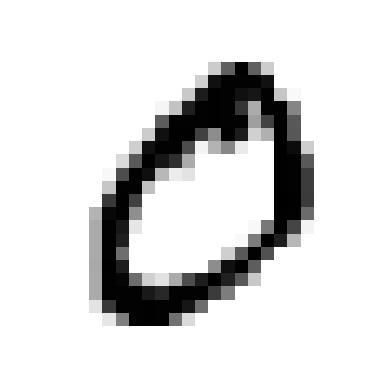

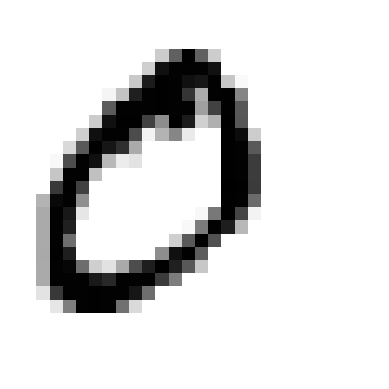

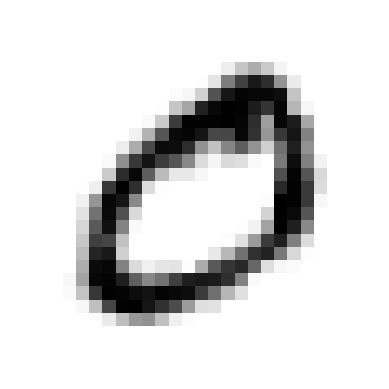

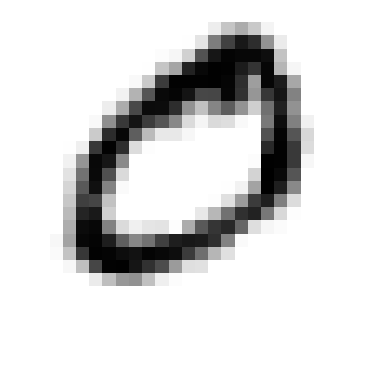

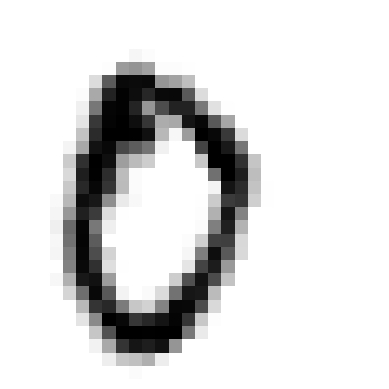

In [14]:
plot_digit(X_train.iloc[1])
plot_digit(T)
plot_digit(R)
plot_digit(S)
plot_digit(V)

Note que essas operações não são comutativas, uma vez que colocamos um fator aleatório. Além disso, faremos apenas translações após termos rotado a imagem, uma vez que não é garantido que, se rotarmos de pois de transladarmos, a rotação respeitará os novos limites da imagem transladada.

Vamos criar agora uma função para gerar dados novos para treino. O usuário pode determinar quantos dados ele quer criar modificando a porcentagem.

In [18]:
def new_data(data,label,percentage):
    S = data.shape[0]
    D = S*percentage/100
    M = data
    N = label
    for i in range(0, int(D)):
        n = randint(0,S-1)
        L = translate(rotation(data.iloc[n]))
        M = pd.concat([M,L],ignore_index=True)
        N = pd.concat([N,pd.Series(label.iloc[n],name='class')],ignore_index=True)
    return M,N

Agora, criemos nosso novo conjunto de treino (aumentado).

In [19]:
m=X_train.copy()
n=y_train.copy()

In [21]:
K = new_data(m,n,30)

Aqui, acredito ser pertintente falar sobre meus dois métodos de encontrar os limites.

Testei duas formas de determinar os limites da translação: a primeira foi a que está acima, a segunda difere da primeira apenas na maneira em que eu encontro os limites da esquerda e da direita. Pensei que talvez meu método fosse muito demorado, por isso testei transpor a matriz e encontrar os limites superior e inferior da transposta (que serias respectivamente os limites esquerda e direita da original). Porém esse método demorou muito mais na criação de novos dados (76min vs 88min para criar 30% a mais de dados). Acredito que isso tenha acontecido pois na minha primeira ideia, eu criei um loop nas linhas a partir de quando eu já sabia que tinham valores não nulos e terminava o loop antes de ter linhas totalmente nulas (ao contrário da transposição de matriz que eu acredito que faça o loop por todas as linhas).

Para poucos dados isso não deve ser um grande problema, mas para nosso conjunto grande, isso deve ser considerado.

In [22]:
X_train_plus = K[0]
y_train_plus = K[1]

Adicionamos 30% a mais de dados ao nosso conjunto de treino. Agora temos 78000 imagens. Porém, note que no meu método, eu adicionei todos os novos dados no final do conjunto antigo de dados, então vamos permutar esse novo conjunto, para que tenhamos imagens rotadas e transladadas espalhadas pelo conjunto treino.

In [23]:
shuffle_index = np.random.permutation(78000)
X_train_plus, y_train_plus = X_train_plus.iloc[shuffle_index], y_train_plus.iloc[shuffle_index]

# Multiclass Classification

Vamos aplicar o GridSearch para escolher os melhores parâmetros para nosso modelo de classificação linear.
Testaremos, na verdade, duas formas de aplicar nossos modelos na classificação. Primeiramente utilizaremos One vs Rest e segundamente o One vs One. Compararemos as performances de ambos usando o score de acuracia.

### OvR

Separa uma classificação de multiplas classes (0,1,...,9) em uma classificação binária (para aplicarmos SVM, por exemplo) considerando cada classe versus todas as outras (vistas como uma classe só).

In [24]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('std_scaler', StandardScaler()),
                 ('estimator', SGDClassifier(max_iter = 10, random_state=42))
             ])

param_grid = [{'estimator__loss' : ['hinge', 'log'],
               'estimator__alpha': [1e-4,5e-4,8e-4,9e-4,1e-3,2e-3,3e-3,5e-3,1e-2,1e-1,1],
               }]

grid_search = GridSearchCV(pipe, param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train_plus, y_train_plus)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
55 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('estimator',
                                        SGDClassifier(max_iter=10,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid=[{'estimator__alpha': [0.0001, 0.0005, 0.0008, 0.0009,
                                               0.001, 0.002, 0.003, 0.005, 0.01,
                                               0.1, 1],
                          'estimator__loss': ['hinge', 'log']}],
             verbose=10)

Façamos uma validação cruzada para avaliarmos a performance.

In [34]:
from sklearn.model_selection import cross_val_score
scores_grid = cross_val_score(grid_search, X_train_plus, y_train_plus, cv=5)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
55 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

Fitting 5 folds for each of 22 candidates, totalling 110 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
55 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

Fitting 5 folds for each of 22 candidates, totalling 110 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
55 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

Fitting 5 folds for each of 22 candidates, totalling 110 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
55 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

Fitting 5 folds for each of 22 candidates, totalling 110 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
55 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

Vejamos os resultados:



In [35]:
scores_grid

array([0.74794872, 0.75346154, 0.75307692, 0.7525641 , 0.75141026])

In [36]:
np.mean(scores_grid)

0.7516923076923077

### OvO

Separa uma classificação de multiplas classes (0,1,...,9) em uma classificação binária (para aplicarmos SVM, por exemplo) considerando cada classe versus as outras individualmente.

In [28]:
from sklearn.multiclass import OneVsOneClassifier

model = Pipeline([('std_scaler', StandardScaler()),
                 ('estimator', SGDClassifier(max_iter = 1000, random_state=42))
             ])

model.set_params(**grid_search.best_params_)
ovo_clf = OneVsOneClassifier(model)

Façamos uma validação cruzada para avaliarmos a performance.

In [29]:
scores = cross_val_score(ovo_clf, X_train_plus, y_train_plus, cv=5)

Vejamos os resultados:

In [30]:
scores

array([0.76083333, 0.75980769, 0.76153846, 0.76115385, 0.76288462])

In [31]:
np.mean(scores)

0.7612435897435897

# Escolha e aplicação do modelo

Note que o score médio do OvO foi melhor que o OvR. Então utilizaremos o OvO para treinar em nosso conjunto de treino aumentado e aplicar em nosso conjunto de treino antigo e depois em nosso conjunto de teste.

In [32]:
from sklearn.metrics  import confusion_matrix

In [33]:
ovo_clf.fit(X_train_plus, y_train_plus)

OneVsOneClassifier(estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('estimator',
                                              SGDClassifier(alpha=0.0005,
                                                            random_state=42))]))

In [38]:
y_pred = ovo_clf.predict(X_train)
conf_mx = confusion_matrix(y_train, y_pred)
conf_mx

array([[5656,   25,   30,   20,   34,   77,   26,   10,   41,    4],
       [   0, 6521,   26,   17,    7,   17,    4,   18,  123,    9],
       [  39,  106, 5293,   85,  130,   26,   68,   62,  132,   17],
       [  37,   96,   96, 5389,   27,  178,   18,   84,  160,   46],
       [   7,   60,   28,    1, 5366,    7,   59,    7,    9,  298],
       [  45,  150,   37,  185,   56, 4679,   66,   29,  118,   56],
       [  34,   55,   49,    0,   83,   83, 5579,    1,   33,    1],
       [  12,   62,   49,   43,  123,    8,    1, 5781,   13,  173],
       [  24,  146,   75,   92,   47,  144,   37,   21, 5187,   78],
       [  33,   43,   21,   59,  142,   23,    3,  139,   61, 5425]])

In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.9146

Obtivemos alta acuracia ao testarmos nosso modelo no conjunto de treino reduzido!

In [40]:
y_pred_test = ovo_clf.predict(X_test)
conf_mx = confusion_matrix(y_test, y_pred_test)
conf_mx

array([[ 914,    2,    8,    2,   10,   23,   13,    4,    2,    2],
       [   0, 1090,    4,    5,    1,    2,    3,    1,   29,    0],
       [  10,   31,  877,   22,   25,    5,   17,   11,   28,    6],
       [   4,   23,   13,  883,    4,   24,    5,   20,   27,    7],
       [   1,   12,    3,    0,  904,    0,   12,    1,    1,   48],
       [   8,   28,    9,   45,   16,  728,   10,    6,   30,   12],
       [  11,   17,    9,    0,   20,   19,  876,    0,    6,    0],
       [   4,   26,   18,   10,   17,    1,    0,  908,    5,   39],
       [   5,   20,   11,   21,   15,   33,    6,   10,  843,   10],
       [   5,   14,    3,   11,   26,    4,    1,   24,   12,  909]])

In [41]:
accuracy_score(y_test, y_pred_test)

0.8932

Obtivemos uma boa acurácia para o conjunto de teste. Porém essa acurácia não foi tão alta quanto à obtida pelo professor ao treinar o modelo OvO apenas no conjunto de treino reduzido. Isso é um pouco contra intuitivo.

Algusn motivos que podem justificar isso seriam:

* A escolha por um modelo mais simples, tanto em quantidade de imagens para treino como em padronização das mesmas (posição e rotação) pode ter se provada novamente mais indicada.

* As rotações e translações podem ter tornado números antes facilmente distinguíveis em números mais semelhantes. Um exemplo disso seria confundir 6 com 9 (que não ocorreu no modelo do professor, mas ocorreu aqui).

* O método de rotação escolhido pode ter causado alguns artefatos na imagem que podem alterar a imagem de maneira a deixar um número semelhante a outro.